# Set up 

In [15]:
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.optimize import minimize
import seaborn as sns
sns.set(style='ticks', context='paper')
colors=["#e3c934","#68c4bf","#c51000","#287271"]
sns.set_palette(colors)

## Library 

In [16]:
def barkbark(cloud,formants,formantchar='F'):
    # cloud = exemplar cloud, dataframe
    # formants = list of formants to be converted (e.g. ["F1","F2"])
    # formantchar = prefix on all formants (e.g. for "f1, f2, f3", use formantchar='f')
    
    # Make a copy of the cloud
    newcloud=cloud.copy()
    
    # For each formant listed, make a copy of the column prefixed with z
    for formant in formants:
        name = str(formant).replace(formantchar,'z')
        
        # Convert each value from Hz to Bark
        newcloud[name] = 26.81/ (1+ 1960/newcloud[formant]) - 0.53
    # Return the dataframe with the changes
    return newcloud

In [65]:
def activation(testset,cloud,dims = {'F0':4,'F1':2,'F2':3,'F3':1},c=0.01):
    # Get stuff ready                                                   
    dims.update((x, (y/sum(dims.values()))) for x, y in dims.items())   # Normalize weights to sum to 1
    
    # If the testset happens to have N in it, remove it before joining dfs 
    test=testset.copy()
    if 'N' in test.columns:
        test = test.drop(columns='N', axis=1,inplace=True)
    
    exemplars=cloud.copy()

    # Merge test and exemplars
    bigdf = pd.merge(
        test.assign(key=1),         # Add column named 'key' with all values == 1
        exemplars.assign(key=1),    # Add column named 'key' with all values == 1
        on='key',                   # Match on 'key' to get cross join (cartesian product)
        suffixes=['_t', '_ex']
    ).drop('key', axis=1)           # Drop 'key' column
    
    
    dimensions=list(dims.keys())                # Get dimensions from dictionary
    weights=list(dims.values())                 # Get weights from dictionary
    tcols = [f'{d}_t' for d in dimensions]      # Get names of all test columns
    excols = [f'{d}_ex' for d in dimensions]    # Get names of all exemplar columns
    
    
    # Multiply each dimension by weights
    i = bigdf.loc[:, tcols].values.astype(float)     # Get all the test columns
    i *= weights                                     # Multiply test columns by weight
    j = bigdf.loc[:, excols].values.astype(float)    # Get all the exemplar columns
    j *= weights                                     # Multiply exemplar columns by weights
    
    # Get Euclidean distance
    bigdf['dist'] = np.sqrt(np.sum((i-j)**2, axis=1))
    
    # get activation: exponent of negative distance * sensitivity c, multiplied by N_j
    bigdf['a'] = np.exp(-bigdf.dist*c)*bigdf.N
    
    return bigdf
    

In [40]:
def exclude(cloud, test, exclude_self=True, alsoexclude=None):    
    # cloud = exemplars, dataframe
    # test = exemplar to be categorized
    # exclude_self = true or false, should the exemplar not be compared to itself? default true
    # exclude = a list of columns in cloud to also exclude
    
    # Make a copy of the cloud and call it exemplars. 
    #    This is what we'll return at the end
    exemplars = cloud.copy()
    
    # Remove the stimulus from the cloud
    if exclude_self == True:
        exemplars=cloud[~cloud.isin(test)].dropna()  
    
    if alsoexclude != None:
        for feature in alsoexclude:
            featval=test[feature].iloc[0]
            exclude_exemps=exemplars[ exemplars[feature] == featval ].index
            exemplars.drop(exclude_exemps, inplace=True)
        
    return exemplars

In [19]:
def reset_N(exemplars, N=1):      # Add or override N, default to 1
    exemplars['N'] = N
    return exemplars

In [20]:
def probs(bigdf,cats):
    prs = {}
    
    # Loop over every category in the list of categories
    for cat in cats: 
        # make that category match the exemplar category in name
        label = cat+'_ex'
        # Sum up activation for every label within that category
        cat_a = bigdf.groupby(label).a.sum()
        # Divide the activation for each label by the total activation for that category
        pr = cat_a/sum(cat_a)
        # rename a for activation to probability
        pr = pr.rename_axis(cat).reset_index().rename(columns={"a":"probability"})
        # add this to the dictionary 
        prs[cat]=pr
    return prs
    

In [21]:
def choose(pr,test,cats,runnerup=False):
    newtest = test.copy()

    for cat in cats:
        choicename = cat + 'Choice'
        choiceprobname = cat + 'Prob'
        
        best2 = pr[cat]['probability'].nlargest(n=2).reset_index(drop=True)        # Get the two highest probs for each cat type
        
        choiceprob = best2[0]                                                      # Match the prob to the category
        choice = pr[cat].loc[pr[cat]['probability']==choiceprob,cat].iloc[0]
        
        newtest[choicename] = choice
        newtest[choiceprobname] = choiceprob
        
        if runnerup == True: 
            choice2name = cat + 'Choice2'
            choice2probname = cat +'Choice2Prob'
            choice2prob = best2[1]                                                      
            choice2 = pr[cat].loc[pr[cat]['probability']==choice2prob,cat].iloc[0]
            newtest[choice2name] = choice2
            newtest[choice2probname] = choice2prob
            
    return newtest

In [22]:
def gettestset(cloud,balcat,n):     #Gets n number of rows per cat in given cattype
    testlist=[]
    for cat in list(cloud[balcat].unique()):
        samp = cloud[cloud[balcat]==cat].sample(n)
        testlist.append(samp)
    test=pd.concat(testlist)
    return test

In [62]:
def multicat(cloud,testset,cats,dims = {'F0':4,'F1':2,'F2':3,'F3':1},c=0.01,exclude_self=True,alsoexclude=None):
    choicelist=[]
    for ix in list(testset.index.values):
        test = testset.loc[[ix,]]
        exemplars=exclude(cloud,test,exclude_self=exclude_self,alsoexclude=alsoexclude)
        reset_N(exemplars)
        bigdf=activation(test,exemplars,dims = dims,c=c)
        pr=probs(bigdf,cats)
        choices = choose(pr,test,cats)
        choicelist.append(choices)
    choices=pd.concat(choicelist, ignore_index=True)
    return choices

In [24]:
def checkaccuracy(choices,cats):
    acc = choices.copy()                     # Make a copy of choices to muck around with
    
    for cat in cats:                     # Iterate over your list of cats
        accname = cat + 'Acc'            # Get the right column names
        choicename = cat + 'Choice'
        
        # If choice is the same as intended, acc =y, else n
        acc[accname] = np.where(acc[cat]==acc[choicename], 'y', 'n')      
    return acc

In [25]:
def propcorr(acc,cat):
    perc = dict(acc.groupby(cat)[cat+'Acc'].value_counts(normalize=True).drop(labels='n',level=1).reset_index(level=1,drop=True))
    pc=pd.DataFrame.from_dict(perc, orient='index').reset_index()
    pc.columns=[cat,'propcorr']
    return pc

In [26]:
def overallacc(acc,cat):
    totalcorrect = acc[cat+'Acc'].value_counts(normalize=True)['y']
    return totalcorrect

In [27]:
# Description

def accplot(pc,cat,acc):
    obs=str(len(acc))
    pl = sns.barplot(x=cat,y='propcorr',data=pc,palette=colors)
    plt.ylim(0,1.01)
    pl.set(ylabel='Proportion accurate of '+obs+' trials')
    pl.set_xticklabels(
    pl.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
    plt.show()

In [28]:
def continuum (start,end,cloud,dimlist = ['F0','F1','F2','F3'],steps=7,df=False):
    vals = {}
    norms = {}
    rowlist = []
    
    st=cloud[cloud['vowel'] == start].sample().reset_index(drop=True) # randomly sample a row with the some start vowel
    spkr = st.speaker.iloc[0]                                         # Get the speaker and gender
    gen = st.gender.iloc[0]
    en=pb52[(cloud.speaker==spkr) & (cloud['vowel']==end)].sample().reset_index(drop=True)  # get a row with the end vowel from same speaker


    for dim in dimlist:                      # Calculate the difference between start and end for each dim
        norms[dim] = en[dim] - st[dim]                               

    for i in range (0,steps):
        for dim in dimlist: 
            vals[dim] = st[dim] + (norms[dim] * i/(steps-1))    # the values for each dim = start val + diff by step
            row = pd.DataFrame(vals)
            row['vowel'] = '?'
            row['speaker'] = spkr
            row['gender'] = gen
        rowlist.append(row)

    rowlist[0]['vowel'] = start                                   # Change start and end vowels
    rowlist[-1]['vowel'] = end
    cont=pd.concat(rowlist,ignore_index=True)             # concatenate

    if df == True:
        return cont
    else:
        return rowlist

In [29]:
def FCN(exemplars,start,end):
    exemplars['N'] = np.where((exemplars['vowel']==start)|(exemplars['vowel']==end), 1, 0)
    return exemplars

## Include other speaker characteristics 

In [30]:
def choosecontinuum(cont,cloud,cats,start,end,FC=False):
    exemplars=cloud.copy()
    exemplars=exemplars[~exemplars.isin(cont)].dropna()
    choicelist = []
    for row in cont: 
        test=row
        if FC == True:
            FCN(exemplars,start,end)
        else:
            reset_N(exemplars)
        bigdf=activation(test,exemplars)
        pr=probs(bigdf,cats)
        choices=choose(pr,test,cats)
        choicelist.append(choices)
    choices=pd.concat(choicelist,ignore_index=True)
    return choices
        

In [31]:
def multiaccplot(choices,cats):
    accuracy = checkaccuracy(choices,cats)
    for cat in cats:
        proportion = propcorr(accuracy,cat)
        accplot(proportion,cat,accuracy)
        print(proportion)

In [32]:
def confusion(choices,cats):
    matrices={}
    for cat in cats:
        matrices[cat]=pd.crosstab(choices[cat],choices[cat+'Choice'],normalize='index').round(2).rename_axis(None)
    return matrices

## data

In [33]:
pb52=pd.read_csv('pb52.csv')

In [58]:
pbbark = barkbark(pb52,["F0","F1","F2","F3"])

# For paper


In [59]:
# Set parameters
cval=55
dimsvals={'z0':1,'z1':2.953,'z2':.924,'z3':3.420}
catslist=['vowel','type']
pbtest=pbbark.copy()
rescats=['type']
subset=gettestset(pbbark,'vowel',50)

In [60]:
testers= gettestset(pbbark,'vowel',5)

In [66]:
choices = multicat(cloud=pbbark,testset=testers,cats=catslist,dims = dimsvals,c=cval,exclude_self=True,alsoexclude=["speaker"])

In [67]:
choices

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3,vowelChoice,vowelProb,typeChoice,typeProb
0,m,m,1,FLEECE,1,160,240,2280,2850,1.493396,2.394727,13.886698,15.355343,FLEECE,0.999990,m,0.999995
1,m,m,2,FLEECE,2,148,210,2360,3250,1.352296,2.064516,14.116204,16.194088,FLEECE,1.000000,m,0.996483
2,w,f,36,FLEECE,2,215,280,2630,3240,2.120184,2.821250,14.831721,16.174692,FLEECE,0.999972,w,0.660325
3,w,f,55,FLEECE,2,241,289,2800,3400,2.405579,2.915127,15.240588,16.476343,FLEECE,1.000000,c,0.748037
4,w,f,43,FLEECE,2,250,325,2900,3500,2.502805,3.283239,15.467737,16.655897,FLEECE,0.999987,c,0.645475
5,m,m,22,KIT,1,136,410,2200,2680,1.209580,4.108017,13.648365,14.955086,KIT,0.978497,m,0.995959
6,w,f,42,KIT,2,230,430,2575,3100,2.285662,4.293556,14.692878,15.895099,KIT,0.867639,w,0.933696
7,c,m,71,KIT,2,250,400,2840,3700,2.502805,4.014068,15.332583,16.995972,FLEECE,0.719528,c,0.999901
8,m,m,19,KIT,1,132,370,1750,2700,1.161644,3.727382,12.116226,15.003691,KIT,0.995042,m,0.996191
9,c,m,72,KIT,1,280,500,2720,3360,2.821250,4.919187,15.051880,16.402632,KIT,0.997737,w,0.773382


## Categorize all data and check accuracy

In [69]:
choices52 = multicat(cloud=pbbark,testset=pbtest,cats=catslist,dims = dimsvals,c=cval,exclude_self=True,alsoexclude=["speaker"])

In [81]:
confs = confusion(choices52,catslist)

In [85]:
pbcm = pd.read_csv('pbcm.csv').drop([0]).set_index('vowelChoice').rename_axis(None)

In [86]:
modelcm = confs['vowel']

In [87]:
pbcmfl=pd.Series(pbcm.stack(),name="PB")
mcmfl=pd.Series(modelcm.stack(),name="GCM")

In [88]:
cms=pd.concat([pbcmfl,mcmfl],axis=1)

In [89]:
cms

PB   GCM
DRESS DRESS    0.658  0.80
      FLEECE   0.013  0.00
      FOOT     0.004  0.00
      GOOSE    0.001  0.00
      KIT      0.237  0.13
...              ...   ...
TRAP  NURSE    0.019  0.01
      PALM     0.040  0.01
      STRUT    0.020  0.01
      THOUGHT  0.000  0.00
      TRAP     0.632  0.84

[100 rows x 2 columns]

In [90]:
(((cms.PB-cms.GCM)**2).mean())**.5

0.0620529612508541

In [91]:
correlation = cms['PB'].corr(cms['GCM'])

In [92]:
correlation

0.9703563472982889

In [93]:
pb52_acc=checkaccuracy(choices52,catslist)
pb52_pc=propcorr(pb52_acc,'vowel')

In [94]:
pb52_pc

,vowel,propcorr
0,DRESS,0.802632
1,FLEECE,0.940789
2,FOOT,0.796053
3,GOOSE,0.809211
4,KIT,0.848684
5,NURSE,0.881579
6,PALM,0.809211
7,STRUT,0.796053
8,THOUGHT,0.782895
9,TRAP,0.842105


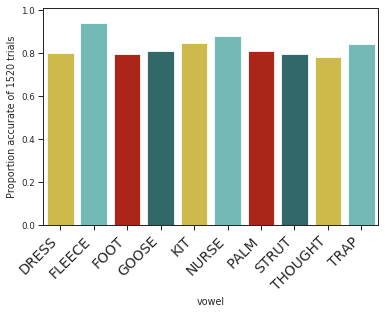

In [95]:
accplot(pb52_pc, 'vowel', pb52_acc)

In [96]:
overallacc(pb52_acc,'vowel')

0.8309210526315789